In [37]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

import os
import sys 

import warnings
warnings.filterwarnings("ignore")

import calendar


# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from scipy import stats


from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler


pd.options.display.float_format = "{:,.2f}".format 

# import plotly_express as px


# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations

import pickle
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Para la codificación de las variables numéricas
# -----------------------------------------------------------------------
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder#, TargetEncoder # para poder aplicar los métodos de OneHot, Ordinal,  Label y Target Encoder 

sys.path.append(os.path.abspath("../../src"))   
import soporte_preprocesamiento as f
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder     #solo me deja hacerlo si uso el entorno default en vez del proyecto
pd.set_option("display.max_columns", None)


In [38]:
df_sinull=pd.read_csv("../../datos/datos5/datos_sin_nulos(pickle).csv", index_col=0).reset_index(drop=True)


In [39]:
df_sinull["hasLift"]

0       True
1      False
2      False
3       True
4      False
       ...  
423     True
424     True
425     True
426    False
427    False
Name: hasLift, Length: 428, dtype: object

In [40]:
df_sinull["rooms"]=df_sinull["rooms"].astype("O")
df_sinull["bathrooms"]=df_sinull["bathrooms"].astype("O")
df_sinull["exterior"]=df_sinull["exterior"].astype("O")

In [41]:
df_sinull.head(2)

,price,propertyType,size,exterior,rooms,bathrooms,province,municipality,distance,status,floor,district,hasLift,parkingSpace
0,750.00,flat,60.00,True,1,1,Madrid,Madrid,7037,good,3,Hortaleza,True,desconocido
1,750.00,flat,70.00,True,2,1,Madrid,San Sebastián de los Reyes,16145,good,bj,Centro Urbano,False,desconocido


In [42]:
df_sinull.duplicated().sum()

np.int64(0)

In [43]:
df_sinull.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         428 non-null    float64
 1   propertyType  428 non-null    object 
 2   size          428 non-null    float64
 3   exterior      428 non-null    object 
 4   rooms         428 non-null    object 
 5   bathrooms     428 non-null    object 
 6   province      428 non-null    object 
 7   municipality  428 non-null    object 
 8   distance      428 non-null    int64  
 9   status        428 non-null    object 
 10  floor         428 non-null    object 
 11  district      428 non-null    object 
 12  hasLift       428 non-null    object 
 13  parkingSpace  428 non-null    object 
dtypes: float64(2), int64(1), object(11)
memory usage: 46.9+ KB


In [44]:
df_sinull_copy=df_sinull.copy()

Se ha comprobado usando value_counts que las columnas con las que contamos tiene sentido mantenerlas pues no domina una categoría frente a la otra de manera exagerada (Es decir que no nos vaya a aportar información relevante)

In [45]:
df_sinull_copy["parkingSpace"].value_counts()

parkingSpace
desconocido    302
True           122
False            4
Name: count, dtype: int64

In [46]:
# df_sinout_copy["municipality"].value_counts()

In [47]:
df_categoricas= df_sinull_copy.select_dtypes("O")

Tenemos 12 columnas de categóricas

In [48]:
df_categoricas.nunique()

propertyType     6
exterior         2
rooms            5
bathrooms        3
province         2
municipality    91
status           4
floor           14
district        96
hasLift          3
parkingSpace     3
dtype: int64

In [49]:
df_categoricas.head()

,propertyType,exterior,rooms,bathrooms,province,municipality,status,floor,district,hasLift,parkingSpace
0,flat,True,1,1,Madrid,Madrid,good,3,Hortaleza,True,desconocido
1,flat,True,2,1,Madrid,San Sebastián de los Reyes,good,bj,Centro Urbano,False,desconocido
2,penthouse,True,2,2,Madrid,Villamanrique de Tajo,good,2,desconocido,False,desconocido
3,flat,False,2,1,Afueras,Recas,good,2,desconocido,True,True
4,flat,True,2,1,Afueras,Cedillo del Condado,good,1,desconocido,False,desconocido


Vamos a recordar la distribución de la categóricas

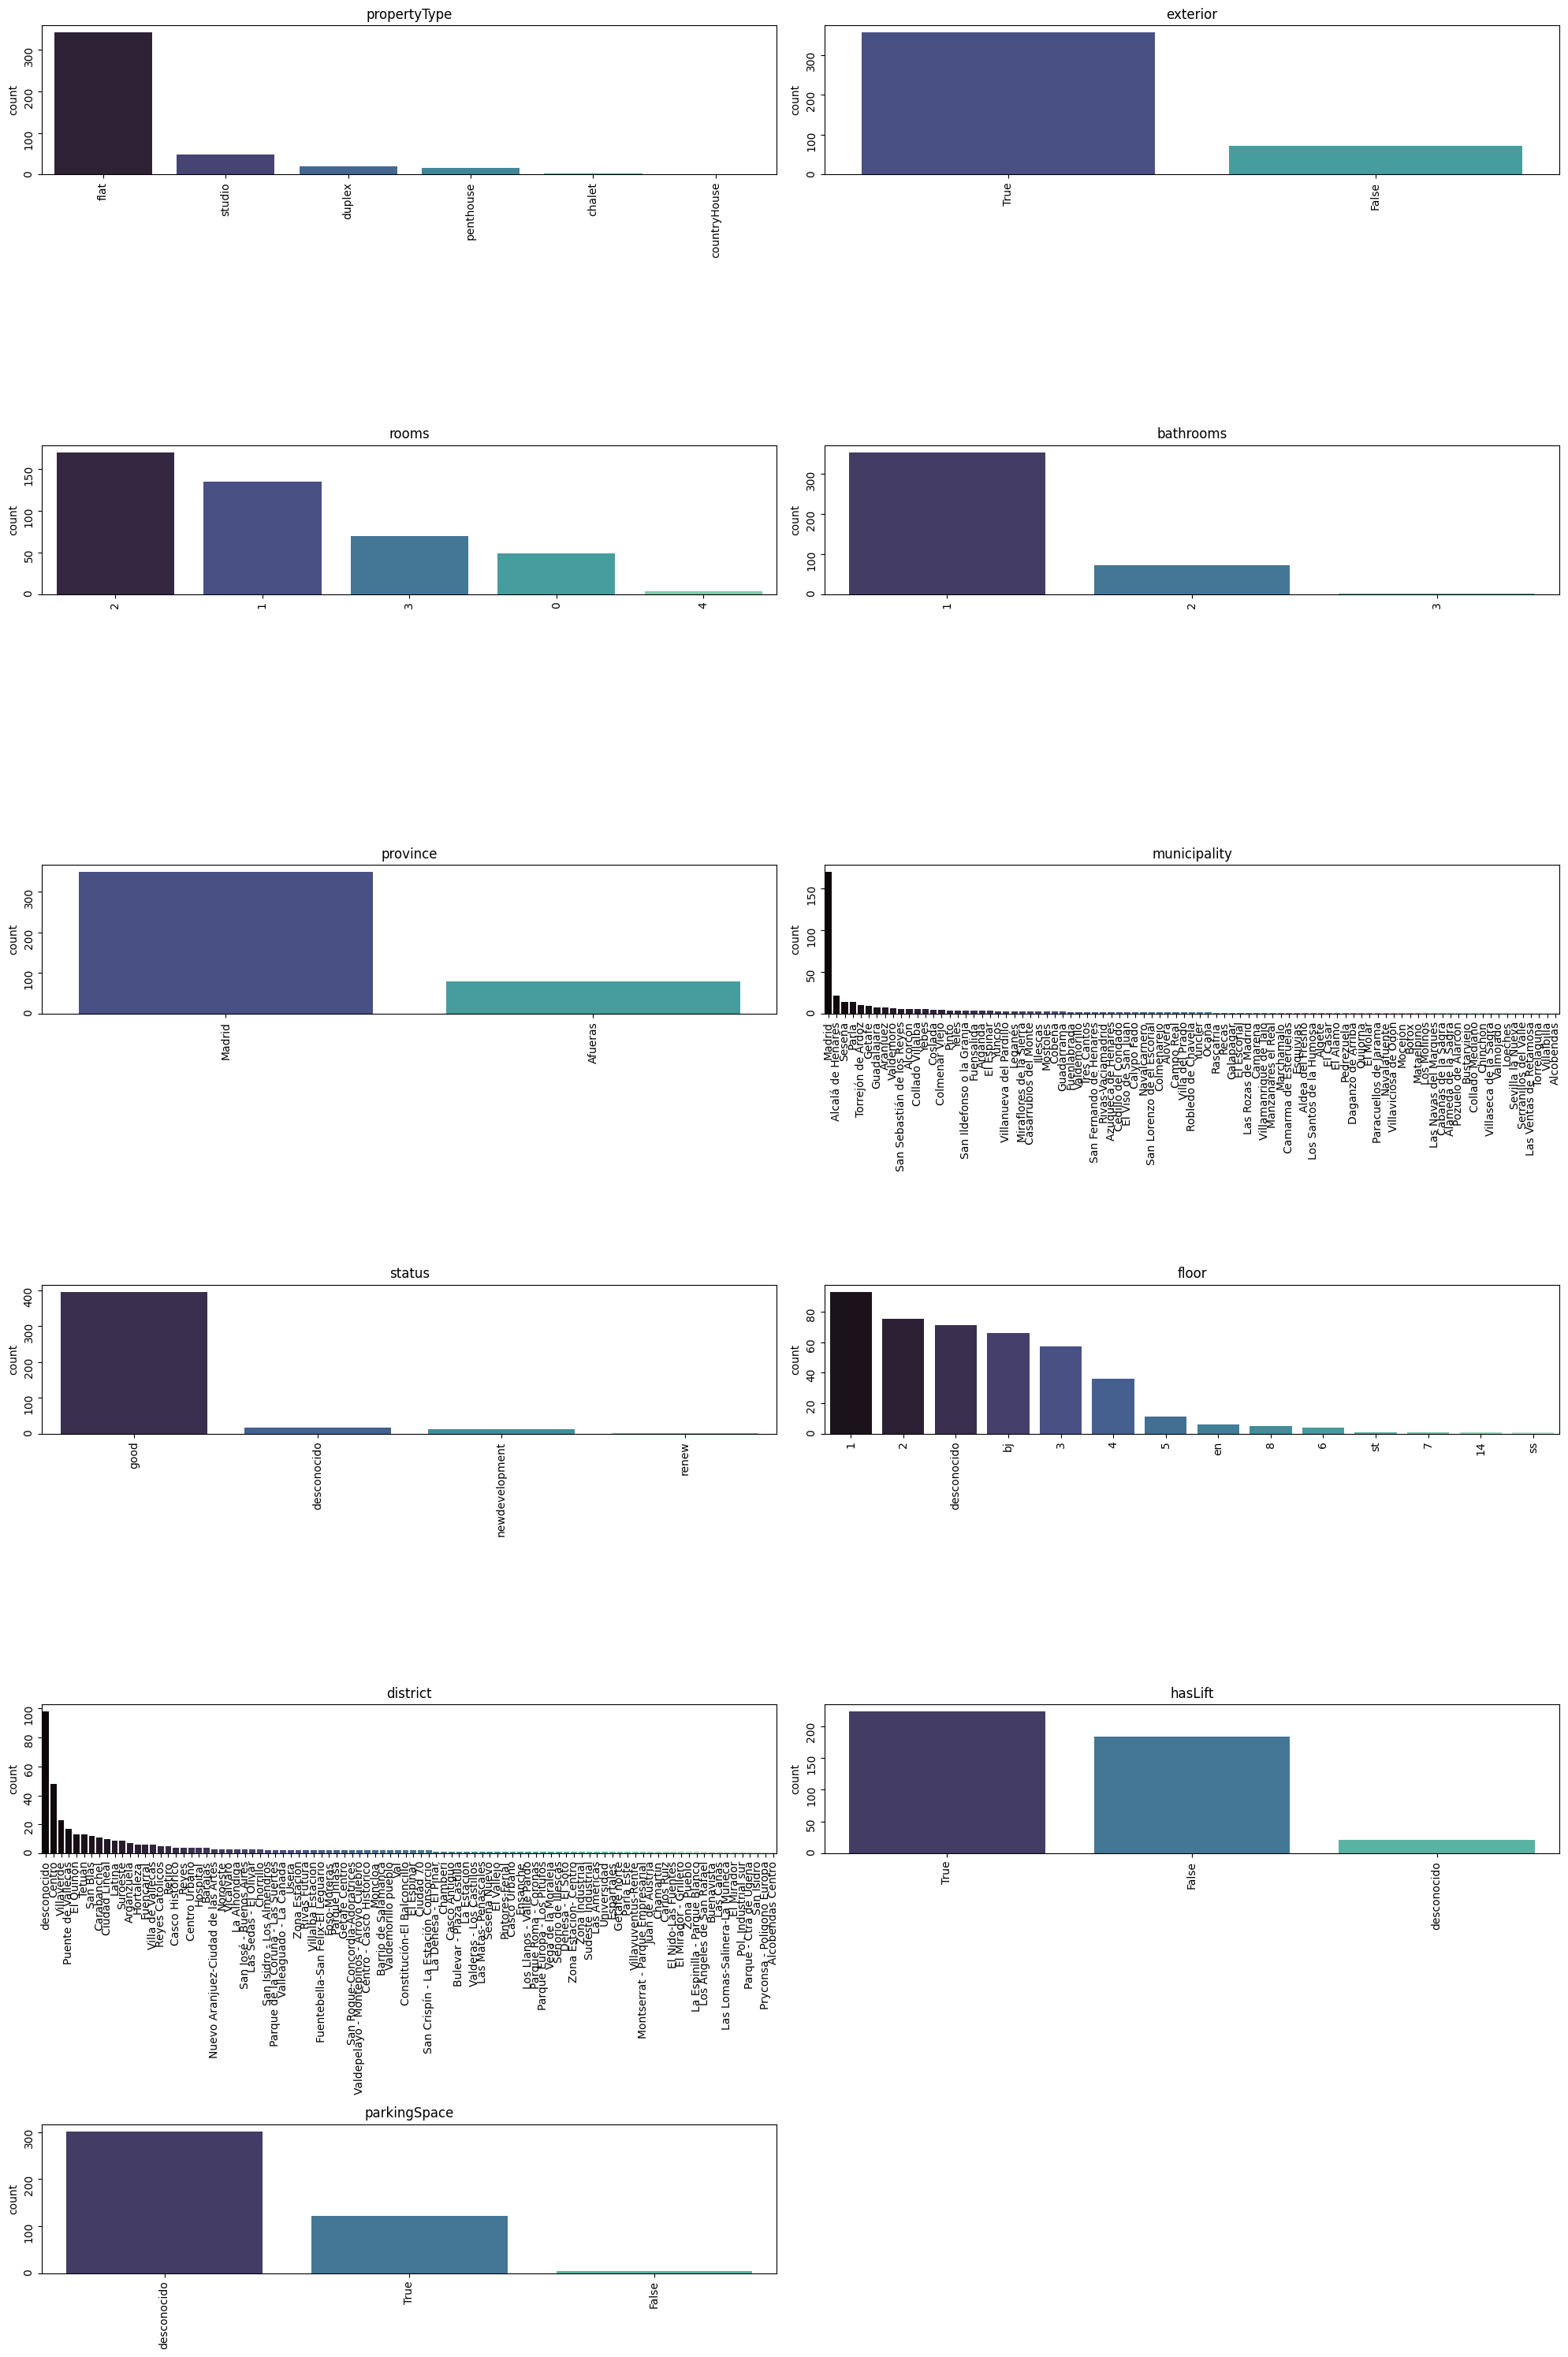

In [50]:
f.plot_categoricas(df_categoricas, (20,30))

Ahora vamos a visualizar la relación entre la dependiente y las categóricas 

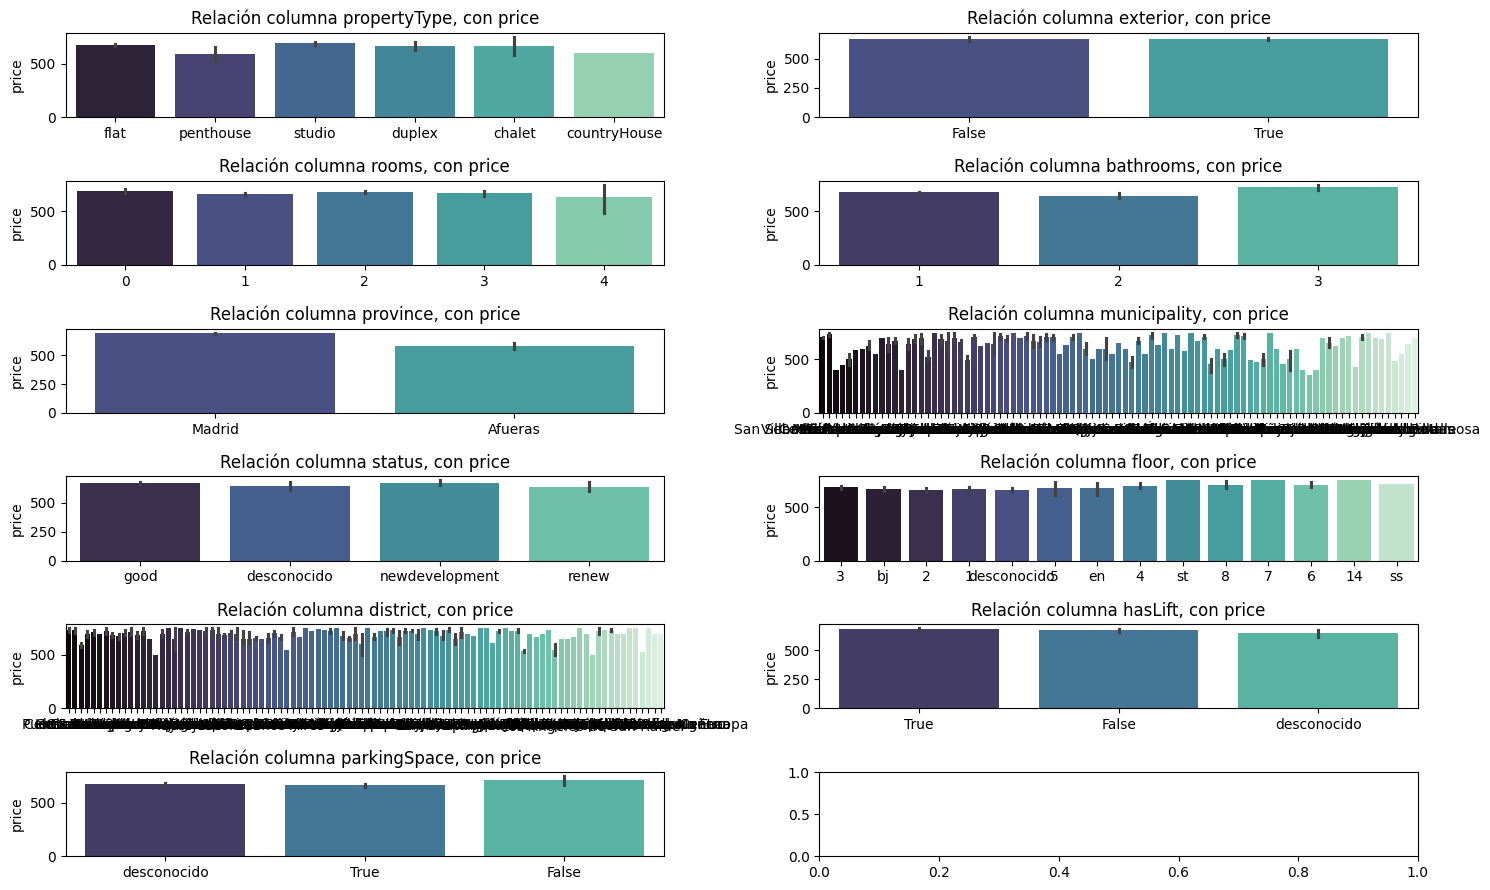

In [51]:
f.visualizar_categoricas(df_sinull_copy, "price", (15,9), "bar")

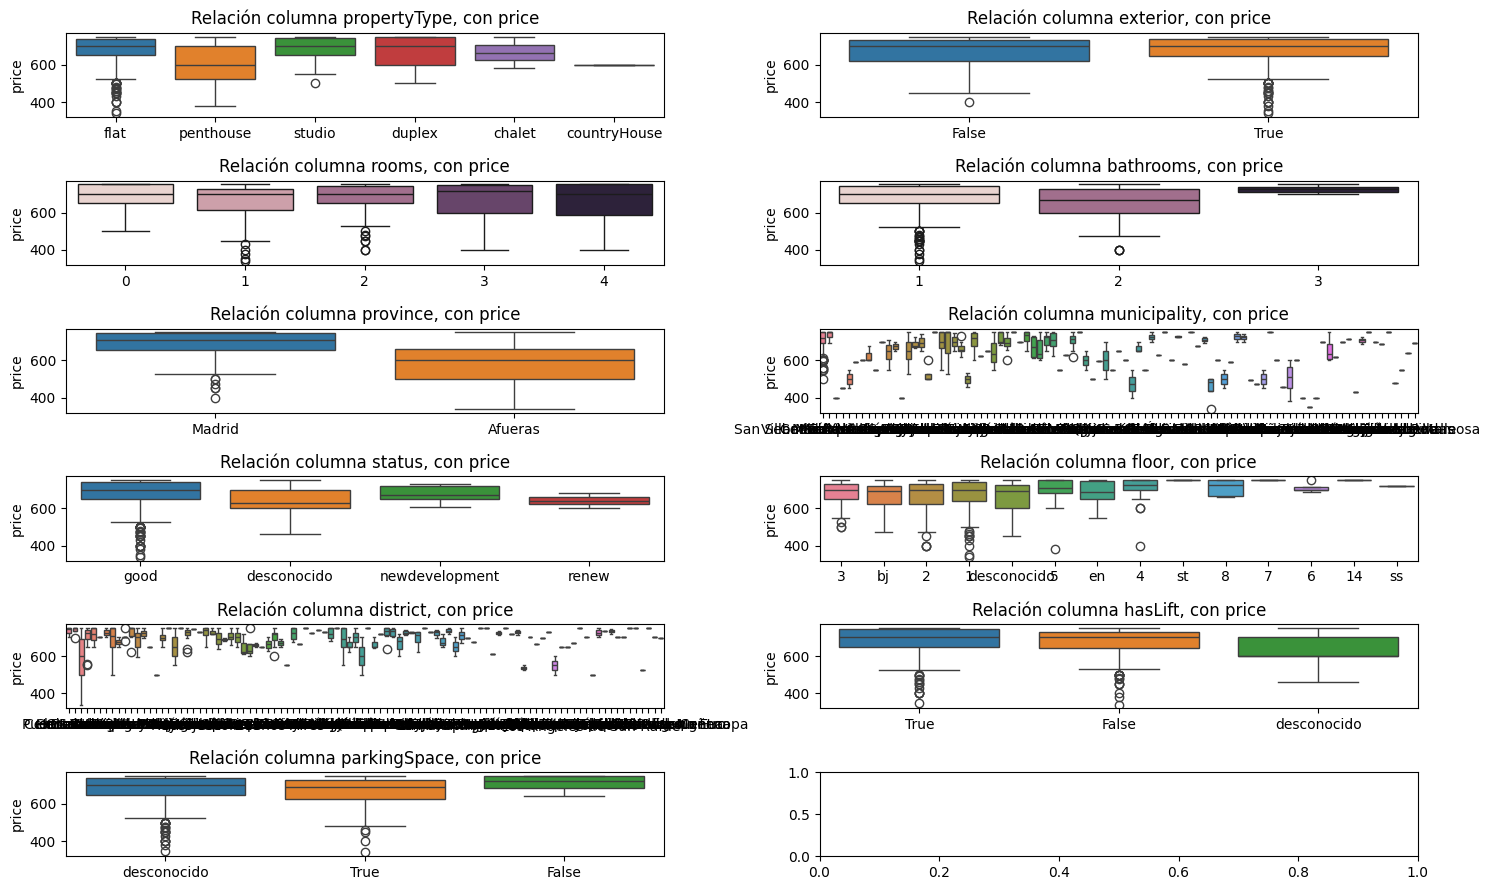

In [52]:
f.visualizar_categoricas(df_sinull_copy, "price", (15,9), "box")

Ahora debemos comprobar la normalidad y homocedasticidad para saber si son parametricas o no parametricas (Con el fin de más adelante poder evaluar si hay diferencias significativas)

Estamos probando primero con kruskal para en aquellas que solo tienen dos categoría comparar con Whitney

Tuve que convertir estas variables a str porque sino no las detectaba como categóricas

In [53]:
df_sinull_copy["exterior"]=df_sinull_copy["exterior"].astype(str)
df_sinull_copy["rooms"]=df_sinull_copy["rooms"].astype(str)
df_sinull_copy["bathrooms"]=df_sinull_copy["bathrooms"].astype(str)

In [54]:
# # llamamos a la clase de Asunciones, para poder decir qué método usar para el análisis estadístico
# asunciones = f.Asunciones(dataframe = df_sinull_copy, columna_numerica= "price")
# print("\n-------------\n")
# lista_col_categ=df_sinull_copy.select_dtypes(include="O")

# for categoria in lista_col_categ:   

#     print(f"Estamos analizando la variable {categoria.upper()}")
    
#     asunciones.identificar_normalidad(metodo = "kolmogorov") 

#     # comprobamos la homogeneidad de varianzas
#     asunciones.identificar_homogeneidad(columna_categorica = categoria)

#     # llamamos la clase de test estadísticos para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
#     test = f.TestEstadisticos(df_sinull_copy, "price", categoria)
#     test.run_all_tests()
#     print("\n###########################\n")

Ahora con Mann-Whitney

In [55]:
# # instanciamos la clase de Asunciones, para poder decir qué método usar para el análisis estadístico
# asunciones = f.Asunciones(dataframe = df_sinull_copy, columna_numerica= "price")
# print("\n-------------\n")
# lista_col_categ=df_sinull_copy.select_dtypes(include="O")

# for categoria in lista_col_categ:   

#     print(f"Estamos analizando la variable {categoria.upper()}")
    
#     asunciones.identificar_normalidad(metodo = "kolmogorov") 

#     # comprobamos la homogeneidad de varianzas
#     asunciones.identificar_homogeneidad(columna_categorica = categoria)

#     # instanciamos la clase para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
#     test = f.TestEstadisticos(df_sinull_copy, "price", categoria)
#     test.run_all_tests()
#     print("\n###########################\n")

Las columnas a comparar entre whitney y kruskal son:  
EXTERIOR  
- MAN: NO HAY DIFERENCIAS 
- KRUSKAL: NO HAY DIFERENCIAS  
  
PROVINCE
- MAN: HAY DIFERENCIAS 
- KRUSKAL: HAY DIFERENCIAS  
  
Aunque las conclusiones no cambien, es más correcto usar la opción de Mann-Whitney y Kruskal combinadas (2º opción).  



#### FIJANDONOS TANTO EN LAS VISUALIZACIONES COMO EN EL TEST DE TUKEY HEMOS OBTENIDO LAS SIGUIENTES CONCLUSIONES:  

**NO ORDENADAS:**
- PROPERTYTYPE
- EXTERIOR
- ROOMS
- STATUS
- FLOOR
- HASLIFT
- PARKINGSPACE   
  
 *- get- dummies (pandas)*  
 *- One-Hot Encoding (SKlearn) (es más efectivo)*  
 *Ambas te crean tantas columnas como categorias hay en la columna y hace que en esa solo valga 1 las que coincidan y 0 el resto*


**ORDENADAS:**  
- BATHROOMS (entre 1 y 2 baños)
- PROVINCE  (entre Madrid y afueras)
- MUNICIPALITY (hay)
- DISTRICT  (hay)
  

*lo de entre parentesis hace referencia a la cantidad de categorías que son diferentes en esa columna*  

*- Ordinal Encoding  (Los codifica en función de los pesos que le digamos)*
*- Label Encoding (Los codifica en orden alfabetico)*  
*- Target Encoding (Los codifica en funcion de las medias (osea en función de la relación con la variable dependiente))*  
*- Frequency Encoding (Los codifica en funcion de la frecuencia(en función del value_counts))*  



**Ahora pasamos al encodin de las que no tienen orden:**

In [56]:
df_sinull_copy.columns

Index(['price', 'propertyType', 'size', 'exterior', 'rooms', 'bathrooms',
       'province', 'municipality', 'distance', 'status', 'floor', 'district',
       'hasLift', 'parkingSpace'],
      dtype='object')

In [57]:
diccionario_encoding = {"onehot": ["propertyType", "exterior", "rooms", "status", "floor", "hasLift", "parkingSpace"], 
                        "dummies": [], # no metemos ninguna
                        'ordinal' : { }, #no metemos ninguna
                        "label": [] , # no metemos ninguna columna porque no queremos en ningún caso que se asignen las categorías de forma aleatoria
                        "frequency": [], # no metemos ninguna columna porque no coincide el orden del value counts con las categorias y la variable respuesta
                        "target": ["bathrooms", "province", "municipality", "district"]  
                        }

In [58]:
# df_copy_cat=df_sinout_copy.select_dtypes("O")

In [59]:
# dfcop=df_sinout_copy.copy()

In [60]:
# encoding=f.Encoding(dataframe = df_sinull_copy , diccionario_encoding= diccionario_encoding, variable_respuesta= "price")
# df_sinull_copy= encoding.one_hot_encoding()
# df_sinull_copy.head()
# #nos genera 40 columnas nuevas aproximadamente

In [61]:
# # Hacemos la gestion de las variables categoricas

# #one_hot_encoder = OneHotEncoder()
# #col_encode = diccionario_encoding.get("onehot", [])
# trans_one_hot = one_hot_encoder.fit_transform(df_sinull_copy[col_encode])
# oh_df = pd.DataFrame(trans_one_hot.toarray(), columns=one_hot_encoder.get_feature_names_out())

# # concatenamos los resultados obtenidos en la transformación con el DataFrame original
# df_sinull_copy = pd.concat([df_sinull_copy.reset_index(drop=True), oh_df.reset_index(drop=True)], axis=1)
# lista_eliminar=["propertyType", "exterior", "rooms", "status", "floor", "hasLift", "parkingSpace"]
# df_sinull_copy.drop(columns=lista_eliminar, inplace=True)


In [62]:
df_sinull_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         428 non-null    float64
 1   propertyType  428 non-null    object 
 2   size          428 non-null    float64
 3   exterior      428 non-null    object 
 4   rooms         428 non-null    object 
 5   bathrooms     428 non-null    object 
 6   province      428 non-null    object 
 7   municipality  428 non-null    object 
 8   distance      428 non-null    int64  
 9   status        428 non-null    object 
 10  floor         428 non-null    object 
 11  district      428 non-null    object 
 12  hasLift       428 non-null    object 
 13  parkingSpace  428 non-null    object 
dtypes: float64(2), int64(1), object(11)
memory usage: 46.9+ KB


Aqui ya está codificada la de abtest en abtest_test vamos a por el resto

In [63]:
# encoder_target= TargetEncoder(cols=["bathrooms", "province", "municipality", "district"])
# encoded= encoder_target.fit_transform(df_sinull_copy , df_sinull_copy[["price"]])
# lista_eliminar=["propertyType", "exterior", "rooms", "status", "floor", "hasLift", "parkingSpace"]
# encoded.drop(columns=lista_eliminar, inplace=True)


In [ ]:
cols_onehot = ["propertyType", "exterior", "rooms", "status", "floor", "hasLift", "parkingSpace"]
one_hot_encoder = OneHotEncoder(categories='auto', 
                        drop=None, 
                        sparse_output=True, 
                        dtype='float', 
                        handle_unknown='error')

encoder_trans = one_hot_encoder.fit_transform(df_sinull_copy[cols_onehot])
encoder_array = encoder_trans.toarray()

# usamos el método get_feature_names_out() para extraer el nombre de las columnas
nombre_columnas = one_hot_encoder.get_feature_names_out()

encoder_df = pd.DataFrame(encoder_array, columns = nombre_columnas)
df_sinull_copy = pd.concat([df_sinull_copy, encoder_df], axis = 1)
df_sinull_copy.drop(columns=cols_onehot, inplace=True)

In [ ]:
with open('../transformers/one_hot_encoder.pkl', 'wb') as f:
    pickle.dump(one_hot_encoder, f)

In [66]:
one_hot_encoder.categories_

[array(['chalet', 'countryHouse', 'duplex', 'flat', 'penthouse', 'studio'],
       dtype=object),
 array(['False', 'True'], dtype=object),
 array(['0', '1', '2', '3', '4'], dtype=object),
 array(['desconocido', 'good', 'newdevelopment', 'renew'], dtype=object),
 array(['1', '14', '2', '3', '4', '5', '6', '7', '8', 'bj', 'desconocido',
        'en', 'ss', 'st'], dtype=object),
 array(['False', 'True', 'desconocido'], dtype=object),
 array(['False', 'True', 'desconocido'], dtype=object)]

In [67]:
target_encoder = TargetEncoder(cols=["bathrooms", "province", "municipality", "district"])
encoded = target_encoder.fit_transform(df_sinull_copy, df_sinull_copy[["price"]])


In [68]:
encoded

,price,size,bathrooms,province,municipality,distance,district,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido
0,750.00,60.00,677.48,693.41,705.59,7037,684.90,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
1,750.00,70.00,677.48,693.41,685.07,16145,683.25,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
2,400.00,67.00,646.96,693.41,637.09,55041,592.06,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
3,450.00,89.00,677.48,582.04,643.59,47186,592.06,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
4,450.00,60.00,677.48,582.04,648.07,38237,592.06,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,640.00,69.00,677.48,693.41,668.31,29311,592.06,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
424,700.00,54.00,677.48,693.41,681.27,11656,671.12,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
425,700.00,59.00,677.48,693.41,705.59,7529,687.16,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
426,700.00,75.00,677.48,693.41,690.44,30359,676.12,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


In [ ]:
with open('../transformers/target_encoder.pkl', 'wb') as f:
    pickle.dump(target_encoder, f)

In [70]:
encoded.head(2)

,price,size,bathrooms,province,municipality,distance,district,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido
0,750.00,60.00,677.48,693.41,705.59,7037,684.90,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
1,750.00,70.00,677.48,693.41,685.07,16145,683.25,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


In [71]:
encoded.columns

Index(['price', 'size', 'bathrooms', 'province', 'municipality', 'distance',
       'district', 'propertyType_chalet', 'propertyType_countryHouse',
       'propertyType_duplex', 'propertyType_flat', 'propertyType_penthouse',
       'propertyType_studio', 'exterior_False', 'exterior_True', 'rooms_0',
       'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4', 'status_desconocido',
       'status_good', 'status_newdevelopment', 'status_renew', 'floor_1',
       'floor_14', 'floor_2', 'floor_3', 'floor_4', 'floor_5', 'floor_6',
       'floor_7', 'floor_8', 'floor_bj', 'floor_desconocido', 'floor_en',
       'floor_ss', 'floor_st', 'hasLift_False', 'hasLift_True',
       'hasLift_desconocido', 'parkingSpace_False', 'parkingSpace_True',
       'parkingSpace_desconocido'],
      dtype='object')

In [72]:
df_final_encoded=encoded[['price', 'size', 'bathrooms', 'province', 'municipality', 'distance',
       'district', 'propertyType_chalet', 'propertyType_countryHouse',
       'propertyType_duplex', 'propertyType_flat', 'propertyType_penthouse',
       'propertyType_studio', 'exterior_False', 'exterior_True', 'rooms_0',
       'rooms_1', 'rooms_2', 'rooms_3', 'rooms_4', 'status_desconocido',
       'status_good', 'status_newdevelopment', 'status_renew', 'floor_1',
       'floor_14', 'floor_2', 'floor_3', 'floor_4', 'floor_5', 'floor_6',
       'floor_7', 'floor_8', 'floor_bj', 'floor_desconocido', 'floor_en',
       'floor_ss', 'floor_st', 'hasLift_False', 'hasLift_True',
       'hasLift_desconocido', 'parkingSpace_False', 'parkingSpace_True',
       'parkingSpace_desconocido']]

In [73]:
df_final_encoded.head()

,price,size,bathrooms,province,municipality,distance,district,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,exterior_False,exterior_True,rooms_0,rooms_1,rooms_2,rooms_3,rooms_4,status_desconocido,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_bj,floor_desconocido,floor_en,floor_ss,floor_st,hasLift_False,hasLift_True,hasLift_desconocido,parkingSpace_False,parkingSpace_True,parkingSpace_desconocido
0,750.00,60.00,677.48,693.41,705.59,7037,684.90,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00
1,750.00,70.00,677.48,693.41,685.07,16145,683.25,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
2,400.00,67.00,646.96,693.41,637.09,55041,592.06,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
3,450.00,89.00,677.48,582.04,643.59,47186,592.06,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00
4,450.00,60.00,677.48,582.04,648.07,38237,592.06,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


In [74]:
df_final_encoded.to_csv("../../datos/datos5/datos_nulos_encoded(pickle).csv")